# Policy Gradient

### Playing CartPole game using Deep Q Learning
Consider the game of CartPole-v0. A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. So, there are 2 actions [Push cart to the left, Push cart to the right] that we can perform on the system. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

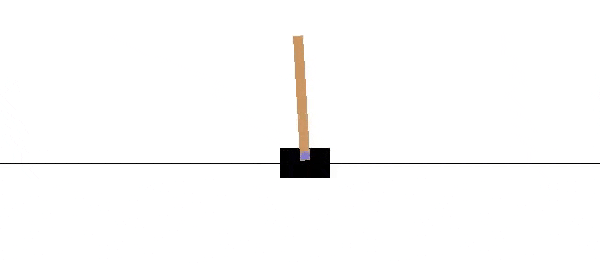

### Define the environment
For the environment, we will be using the open source gym library. Given an action, the environment will give the next state, reward, and will also tell if the game has ended or not. 

Source: https://gym.openai.com/docs/

Reference: https://github.com/rlcode/reinforcement-learning

### Notation:
1. '<b>Observation</b>' is used instead of '<b>State</b>'. Both are same.
2. <b>Episode</b>: Episode is a sequence of states, actions and rewards, until the terminal state is reached. 
3. <b>reward</b>: Immmediate reward after taking an action
4. <b>done</b>: Check if the episode has reached the terminal state

### Sample code for using the gym library
```python
import gym
env = gym.make('CartPole-v0')
for i_episode in range(20):
    observation = env.reset()
    for t in range(100):
        env.render()
        print(observation)
        action = env.action_space.sample()
        # Take action in the current state, the environment will next state (observation), get reward and check if has reached the end state
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
```

### Model

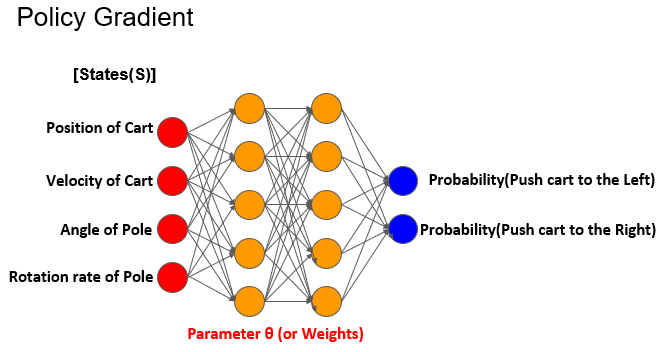



### Training the model:
1. Build neural network with input as states and output as probabilities over actions.
   Suppose we sample 3 action from probability distribution p=[0.1, 0, 0.3, 0.6, 0], we will get actions as [3, 3, 0]
   
   Ex: Input:  $np.random.choice(5, 3, p=[0.1, 0, 0.3, 0.6, 0])$ Output: $array([3, 3, 0])$
       
2. Generate samples $<s, a, r>$ until the end of the episode $<0$ to $T-1>$. Action has to be generated according to the neural network. 
3. Save each sample $<s, a, r>$
4. For each path in the episode, we will update the paramters of neural network(Policy network)
   Suppose there are 3 steps in a episode: $<s0,a1,r1, s1,r2,a2, s2,r3,a3>$
   Here, we will update the policy for 3 paths:
        
                1. <s0,a1,r1, s1,r2,a2, s2,r3,a3>
                2. <s1,r2,a2, s2,r3,a3>
                3. <s2,r3,a3>
                
5. $G_t = r_t + γ r_{t+1} + γ^2 r_{t+2} + ... + γ^{T-t} r_T$, where T is the last timestep of the episode.   
   Here, the batch size will be 3 and there will be 3 G_t corrosponding to each path.  
   
6. To reduce variance, we will normalize the discounted reward 

7. Loss Function: Compute the loss for a given batch. The update for REINFORCE is:
        
           θ = θ + α ∇_θ log π_θ(s, a) G_t. 
           θ = θ - α ∇_θ (- log π_θ(s, a) G_t)
           θ = θ - α ∇_θ (cross-entropy loss)
           
    Comparing this update rule to categorical cross entropy loss, log π_θ(s, a) is the output that we will get after softmax activation and G_t is like label.
  
8. The label in cross-entropy loss function will be G_t. 
            
9. We will update the parameters for which action is taken. Suppose there are 2 actions that we can take at a particular state: A1 and A2 and their corrosponding G_t is G1 and G2. Now, suppose we take second action A2. Therefore, the label will become [0, G2] and not [G1, G2]. 
            
10. Therefore, advantage will be [0,G2]

Lets start the code. 

Importing libraries

In [1]:
import sys
import gym
import pylab
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import model_from_json



C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Defining number of episodes to train
EPISODES = 1000

In [3]:
import os
directory_model = 'save_model'
directory_graph = 'save_graph'

#directory = 'save_graph'
if not os.path.exists(directory_model):
    os.makedirs(directory_model)

if not os.path.exists(directory_graph):
    os.makedirs(directory_graph)  

### Define REINFORCE Agent class
In the class, we will define the following functions:
1. Function(build_model) - Input : States, Output : Possible Actions
2. Function(get_action) - Input: States. We generate the possible actions over state through model. Define policy to choose a action over possible action. Output : Action
3. Function(discounted_rewards) - Input: Rewards. Output : Total discounted reward over the episode
4. Function(append_sample) - Input : state, action, Reward. It acts like memory. Will be used during training. 
5. Function(train_model) : This function will train the model with the parameter theta(or weights). 




In [4]:
class REINFORCEAgent:
    def __init__(self, state_size, action_size):
        # if you want to see Cartpole learning, then change to True
        self.render = False
        self.load_model = False
        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # These are hyper parameters for the Policy Gradient
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.hidden1, self.hidden2 = 24, 24

        # create model for policy network
        self.model = self.build_model()

        # lists for the states, actions and rewards
        self.states, self.actions, self.rewards = [], [], []
        
        self.save_model_graph()

        #if self.load_model:
        #self.model.load_weights("./save_model/cartpole_reinforce.h5")

    # approximate policy using Neural Network
    # state is input and probability of each action is output of network
    def build_model(self):
        '''
        TODO:
        Build multilayer perceptron for training the policy function. The input to the model will be the states.
        The ouput will be probability distribution over actions. Here, we are using softmax activation to find 
        distribution over actions. 
        
        Loss:
        Compute the loss for a given batch. The update for REINFORCE is:
        
           θ = θ + α ∇_θ log π_θ(s, a) G_t. 
           
           Comparing this update rule t0 categorical cross entropy in neural network, log π_θ(s, a) is the output that
           we will get after softmax activation and G_t is like label. 
           
        Return: Return the model   
        '''
        model = Sequential()
        model.add(Dense(self.hidden1, input_dim=self.state_size, activation='relu', kernel_initializer='glorot_uniform'))
        model.add(Dense(self.hidden2, activation='relu', kernel_initializer='glorot_uniform'))
        model.add(Dense(self.action_size, activation='softmax', kernel_initializer='glorot_uniform'))
        model.summary()
        model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=self.learning_rate))
        return model
    
    def save_model_graph(self):
        # serialize model to JSON
        model_json = self.model.to_json()
        with open("./save_model/cartpole_reinforce_model.json", "w") as json_file:
            json_file.write(model_json)


    # using the output of policy network, pick action stochastically
    def get_action(self, state):
        
        '''
        Args:
          state: Any given state in a environment
          
        TODO:
        Find the action that will give maximize the probability of taking the best action. Neural network will give the
        probability distribution of action over states. We sample action according to the probability distribution. 
        Suppose we sample 3 action from probability distribution p=[0.1, 0, 0.3, 0.6, 0], we will get actions as [3, 3, 0]
        Ex: Input:  np.random.choice(5, 3, p=[0.1, 0, 0.3, 0.6, 0])
            Output: array([3, 3, 0])
            https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html
        
        '''
        policy = self.model.predict(state, batch_size=1).flatten()
        return np.random.choice(self.action_size, 1, p=policy)[0]

    # In Policy Gradient, Q function is not available.
    # Instead agent uses sample returns for evaluating policy
    def discount_rewards(self, rewards):
        '''
        Args: 
          rewards: List of sample reward at each timestep in a sample episode
          
        In Policy Gradient, Q function is not available. Instead agent uses sample returns for evaluating policy.
        We need to calculate the advantages to update the policy, we will use the discounted reward, G_t.
    
        G_t = r_t + γ r_{t+1} + γ^2 r_{t+2} + ... + γ^{T-t} r_T
    
             where T is the last timestep of the episode.

        TODO: compute G_t for each timestep in a episode 
        
        Return: G_t
        '''
        # Initialising the discounted_reward Gt for all the sample return in a particualar epsiode
        discounted_rewards = np.zeros_like(rewards)
        running_add = 0
        
        # Calcutate discounted_reward Gt for all the sample return in a particular epsiode, using discount factor
        # G_t = r_t + γ r_{t+1} + γ^2 r_{t+2} + ... + γ^{T-t} r_T
        # G_t = r_t + γ (G_{t+1})
        # To calculate G_t, at time t, we need G_{t+1},at t+1, so we are calculating in reverse direction
        
        for t in reversed(range(0, len(rewards))):
            running_add = running_add * self.discount_factor + rewards[t]
            discounted_rewards[t] = running_add
        return discounted_rewards

    # save <s, a ,r> of each step
    def append_sample(self, state, action, reward):
        '''
        Args: 
            state, action, reward
        TODO: 
        save sample <s, a ,r> of each step in episode. We will use this sample during training.
        '''
        self.states.append(state)
        self.rewards.append(reward)
        self.actions.append(action)

    # update policy network every episode
    def train_model(self):
        '''
        Update the paremeters of the neural network
        
        TODO:
            1. Length of the episode is equal to number of states in a given episode
            
            2. Batch size is the length of episode
            
            3. For each path in the episode, we will update the paramters of neural network(Policy network)
            Suppose there are 3 steps in a episode:
            <s0,a1,r1, s1,r2,a2, s2,r3,a3>
            Here, we will update the policy for 3 paths:
            
                1. <s0,a1,r1, s1,r2,a2, s2,r3,a3>
                2. <s1,r2,a2, s2,r3,a3>
                3. <s2,r3,a3>
                
            So, the batch size will be 3 and there will be 3 G_t corrosponding to each path. 
            
            4. To reduce variance, we will normalize the discounted reward 
            
            5. The label in cross-entropy loss function will be G_t. 
            
            6. We will update the parameters for which action is taken. Suppose there are 2 actions that we can 
            take at a particular state: A1 and A2 and their corrosponding G_t is G1 and G2. Now, suppose we take second 
            action A2. Therefore, the label will become [0, G2] and not [G1, G2]. 
            
            7. Therefore, advantage will be [0,G2]
        '''
        # since we are story all the states in a episode, the length of states will length of episode(episode_length)
        # Here, self.state is list of all the states in a episode    
        episode_length = len(self.states)

        # Calculate the discounted reward for all sample in a episode
        # Here, self.reward is list of all the individual rewards that we get when we transition from a state
        discounted_rewards = self.discount_rewards(self.rewards)
        discounted_rewards -= np.mean(discounted_rewards)
        discounted_rewards /= np.std(discounted_rewards)

        # Create batch of batch size equal(episode_length) to total number of samples in a particular episode (0 to T-1)
        # Update input will have every state in a particular episode, where state size is here 4.
        # Advantage will have total discounted reward starting from the state defined in update_state. 
        # It will have total discounted reward for all the states
        # So, batch size will be same for both the update_inputs and advantages. Initializing both with zeros.
        update_inputs = np.zeros((episode_length, self.state_size))
        advantages = np.zeros((episode_length, self.action_size))
        
        # Setting the update_reward with states in the episode
        # Setting the advantage with discounted reward G_t for only the action that policy has taken 
        # For other possible actions, which we have not taken, advantage will be zero. 

        for i in range(episode_length):
            update_inputs[i] = self.states[i]
            advantages[i][self.actions[i]] = discounted_rewards[i]

        self.model.fit(update_inputs, advantages, epochs=1, verbose=0)
        self.states, self.actions, self.rewards = [], [], []


## Train the network
First, we will generate a whole episode and store the sample $<s, a, r>$ to the memory. After the completion of episode, we will train the model using sample $<s, a, r>$ and reset the environment. 

The steps are:
1. Generate the sample <state, action, reward> until the end of the episode
2. Save samples <state, action, reward>
3. If episode is generated, then calculate G_t for each possible path in a episode
4. Update the model 
5. Generate a new episode

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
episode: 0   score: 33.0
episode: 1   score: 31.0
episode: 2   score: 11.0
episode: 3   score: 10.0
episode: 4   score: 19.0
episode: 5   score: 8.0
episode: 6   score: 15.0
episode: 7   score: 12.0
episode: 8   score: 20.0
episode: 9   score: 27.0
episode: 10   score: 45.0
episode: 11   score: 17.0
episode:

episode: 278   score: 41.0
episode: 279   score: 18.0
episode: 280   score: 18.0
episode: 281   score: 12.0
episode: 282   score: 18.0
episode: 283   score: 24.0
episode: 284   score: 29.0
episode: 285   score: 15.0
episode: 286   score: 36.0
episode: 287   score: 72.0
episode: 288   score: 47.0
episode: 289   score: 25.0
episode: 290   score: 13.0
episode: 291   score: 13.0
episode: 292   score: 15.0
episode: 293   score: 74.0
episode: 294   score: 25.0
episode: 295   score: 35.0
episode: 296   score: 40.0
episode: 297   score: 18.0
episode: 298   score: 23.0
episode: 299   score: 22.0
episode: 300   score: 21.0
episode: 301   score: 34.0
episode: 302   score: 15.0
episode: 303   score: 12.0
episode: 304   score: 9.0
episode: 305   score: 11.0
episode: 306   score: 11.0
episode: 307   score: 27.0
episode: 308   score: 63.0
episode: 309   score: 48.0
episode: 310   score: 19.0
episode: 311   score: 16.0
episode: 312   score: 29.0
episode: 313   score: 19.0
episode: 314   score: 35.0
ep

episode: 580   score: 255.0
episode: 581   score: 500.0
episode: 582   score: 161.0
episode: 583   score: 230.0
episode: 584   score: 124.0
episode: 585   score: 474.0
episode: 586   score: 124.0
episode: 587   score: 250.0
episode: 588   score: 238.0
episode: 589   score: 440.0
episode: 590   score: 426.0
episode: 591   score: 169.0
episode: 592   score: 105.0
episode: 593   score: 500.0
episode: 594   score: 250.0
episode: 595   score: 500.0
episode: 596   score: 466.0
episode: 597   score: 500.0
episode: 598   score: 500.0
episode: 599   score: 500.0
episode: 600   score: 158.0
episode: 601   score: 392.0
episode: 602   score: 500.0
episode: 603   score: 258.0
episode: 604   score: 500.0
episode: 605   score: 500.0
episode: 606   score: 500.0
episode: 607   score: 500.0
episode: 608   score: 235.0
episode: 609   score: 500.0
episode: 610   score: 433.0
episode: 611   score: 500.0
episode: 612   score: 500.0
episode: 613   score: 500.0
episode: 614   score: 500.0
episode: 615   score

SystemExit: 

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


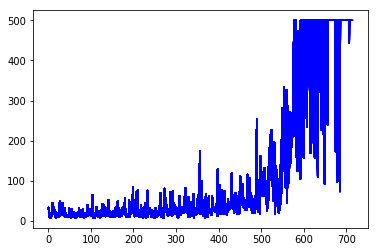

In [5]:
if __name__ == "__main__":
    # In case of CartPole-v1, you can play until 500 time step
    env = gym.make('CartPole-v1')
    # get size of state and action from environment
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # make REINFORCE agent
    agent = REINFORCEAgent(state_size, action_size)

    scores, episodes = [], []

    for e in range(EPISODES):
        done = False
        score = 0
        
        # Resetting the environment after every episode
        state = env.reset()
        
        # Reshaping in the form of (batch_size), state_size for input to neural network
        state = np.reshape(state, [1, state_size])

        while not done:
           # if agent.render:
            #    env.render()

            # get action for the current state and go one step in environment
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            reward = reward if not done or score == 499 else -100

            # save the sample <s, a, r> 
            agent.append_sample(state, action, reward)

            score += reward
            state = next_state
            
            # Make state transition until end of the episode. After the end of episode, we will update the theta of policy
            # That is we train the neural network 
            if done:
                # every episode, agent learns from sample returns
                agent.train_model()

                # every episode, plot the play time
                score = score if score == 500 else score + 100
                scores.append(score)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                pylab.savefig("./save_graph/cartpole_reinforce.png")
                print("episode:", e, "  score:", score)

                # if the mean of scores of last 10 episode is bigger than 490
                # stop training
                if np.mean(scores[-min(30, len(scores)):]) > 490:
                    sys.exit()

        #save the model
        if e % 50 == 0:
            agent.model.save_weights("./save_model/cartpole_reinforce.h5")


In [6]:
print("Done")

Done
